# MY NOTEBOOK

## CONFIG

In [1]:
%load_ext autoreload
%autoreload

### Imports

In [2]:
import os
import fnmatch
import re
import random
import time
import sys
import warnings

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from tqdm import tqdm_notebook as tqdm
from time import sleep

from models import *

## Constants

### Local Machine

In [3]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

SUB_DIRS = "0123456789abcdef"

LOGDIR = "checkpoints/"

AUDIO1_path = "../MTT/mtt_data_mp3.zip/0/american_bach_soloists-j_s__bach_\
_transcriptions_of_italian_music-02-concerto_in_a_minor_for_four_harpsichords\
_bwv_1065_ii_largo-88-117.mp3"

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [4]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# need to create this directory on the server !!
LOGDIR = "checkpoints/"

SUB_DIRS = "0123456789abcdef"

### Data

In [5]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984
# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

TRAIN_DIR = "0123456789abcde"
TEST_DIR ="f"

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001

### Mutable parameters

In [7]:
# Variables which are often modified to test the algorithm
NB_SONGS = 20
EPOCHS = 50 # check in paper
LABELS_NAME = ['guitar', 'techno']
NB_LABELS = len(LABELS_NAME)

## Loading tool functions

In [8]:
def load_labels(labels_file_name):
    pd.read_csv(labels_file_name)

def randomize_files(files):
    for file in files:
        file_index = random.randint(0, (len(files) - 1))
        yield files[file_index]


# ATTENTION : in the current configuration, everytime this function is called it goes through 
# all the sub-directories even if the sample is set to 6
# it only prunes the output at the end
# > there could be a more efficient way for doing this
# TODO later
def find_files(directory, pattern='*.mp3', sample=None, sub_dir=None):
    '''Recursively finds all files matching the pattern.'''
    # subdir sould be a string, for example "abc03", 
    # meaning we take data from directories a,b,c,0 and 3
    
    files = []
    directories = []
    
    # TODO : add lines to check format of input
    # TODO : try/except ?
    
    if sub_dir!=None :
        for c in sub_dir :
            directories.append(directory+c+"/")
    else :
        directories.append(directory)
    
    for path in directories :
        for root, dirnames, filenames in os.walk(path):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))

    if sample!=None :
        try:
            return files[:sample]
        except TypeError:
            print("Argument sample should be either None, or an integer :\
             the number of first n samples to take.")
    else :
        return files

## Prediction labels

### Load and clean

In [9]:
start = time.time()
labels = pd.read_csv(LABELS_FILE, sep = '"\t"')
end = time.time()
print("Duration : {:.3}".format(end-start))

/home/jjgweber/semester_project/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Duration : 3.65


In [10]:
# Prepare header to put back in the end
# remove quotes and take all columns except the first one
header = list(map(lambda x : x.replace('"', ''), labels))[1:]
# add back the first column, separated in two
header = ['clip_id', 'no_voice']+header
# create dictionary
header = dict(enumerate(header))

In [11]:
# Solve format problem : two first columns are merged
# extract first column and rest
left, right = labels['"clip_id\t""no voice"'], labels.iloc[:, 1:]
# split first column in two part at separator "\t"
split = left.str.split(pat = "\t", expand=True).replace('"', '')

# put back the first column which is now two, with the rest
cleaned = pd.concat([split, right], axis=1, ignore_index=True) 
# clean by removing quotes and add back header
cleaned = cleaned.apply(lambda col : col.apply(lambda x : x.replace('"', ''))).rename(columns = header)
cleaned.head(5)

,clip_id,no_voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


### Analyse the dataset

In [12]:
## TODO : Some statistics on the MTT dataset ?
nb_labels_per_song = cleaned.iloc[:,1:-1].astype(int).sum(axis=1)
nb_song_per_label = cleaned.iloc[:,1:-1].astype(int).sum(axis=0)
nb_song_per_label = nb_song_per_label.sort_values(ascending=False)

In [13]:
# label header is the header without clip_id and mp3_path > length 188 instead of 190
label_header = np.asarray(list(header.values()))[1:-1]
label_header_by_freq = np.asarray(nb_song_per_label.index)

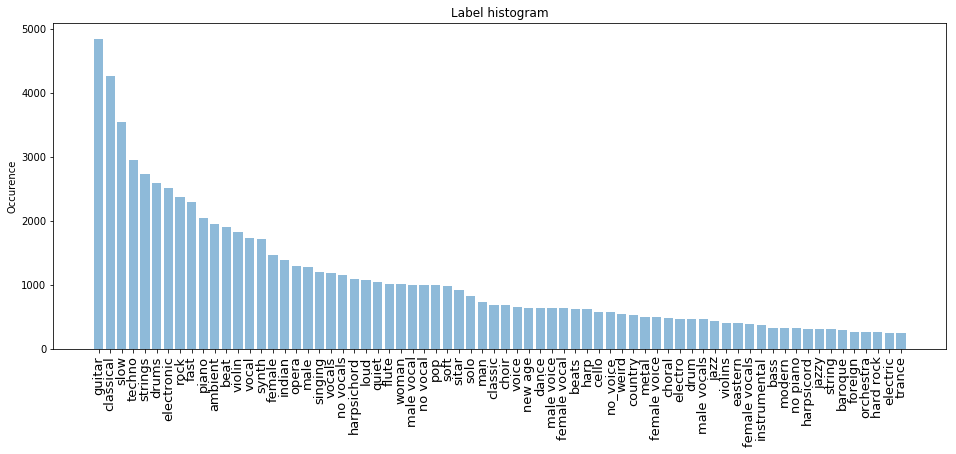

In [14]:
fig = plt.figure(figsize=(16,6))

plot_nb = 70

y_pos = np.arange(plot_nb)
plt.bar(y_pos, nb_song_per_label[:plot_nb], align='center', alpha=0.5)
plt.xticks(y_pos, nb_song_per_label[:plot_nb])
plt.ylabel('Occurence')
plt.title('Label histogram')
plt.xticks(np.arange(plot_nb), label_header_by_freq[:plot_nb], rotation=90, fontsize = 13)

plt.show()

In [15]:
# Find the most frequent labels to start with for training
most_freq = nb_song_per_label
for i in range(len(nb_song_per_label)) :
    if nb_song_per_label[i] > 2000:
        print(i, "> ", label_header_by_freq[i], " -- ", nb_song_per_label[i])

0 >  guitar  --  4852
1 >  classical  --  4272
2 >  slow  --  3547
3 >  techno  --  2954
4 >  strings  --  2729
5 >  drums  --  2598
6 >  electronic  --  2519
7 >  rock  --  2371
8 >  fast  --  2306
9 >  piano  --  2056


In [16]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

In [17]:
print("Number of songs : " , cleaned.shape[0])
print("Number of labels : " , cleaned.shape[1]-2) # -2 is for index columns and mp3 path column
print("Max number of songs tagged with the same label : ",max(nb_song_per_label))
print("Max number of labels for a single song : ",max(nb_labels_per_song))

Number of songs :  25863
Number of labels :  188
Max number of songs tagged with the same label :  4852
Max number of labels for a single song :  27


## Co-occurence matrix

Code from : https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas

In [18]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    #from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))



def check_overlaps(label_headers, label_data):


    print('labels:\n{0}'.format(label_data))

    # Compute cooccurrence matrix 
    cooccurrence_matrix = np.dot(label_data.transpose(),label_data)
    print('\ncooccurrence_matrix:\n{0}'.format(cooccurrence_matrix)) 

    # Compute cooccurrence matrix in percentage
    # FYI: http://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element
    #      http://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero/32106804#32106804
    cooccurrence_matrix_diagonal = np.diagonal(cooccurrence_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        cooccurrence_matrix_percentage = np.nan_to_num(np.true_divide(cooccurrence_matrix, \
                                                                      cooccurrence_matrix_diagonal[:, None]))
    print('\ncooccurrence_matrix_percentage:\n{0}'.format(cooccurrence_matrix_percentage))

    # Add count in labels
    label_header_with_count = [ '{0} ({1})'.format(label_header, cooccurrence_matrix_diagonal[label_number]) \
                               for label_number, label_header in enumerate(label_headers)]  
    print('\nlabel_header_with_count: {0}'.format(label_header_with_count))

    # Plotting
    x_axis_size = cooccurrence_matrix_percentage.shape[0]
    y_axis_size = cooccurrence_matrix_percentage.shape[1]
    title = "Co-occurrence matrix\n"
    xlabel= ''#"Labels"
    ylabel= ''#"Labels"
    xticklabels = label_header_with_count
    yticklabels = label_header_with_count
    heatmap(cooccurrence_matrix_percentage, title, xlabel, ylabel, xticklabels, yticklabels)
    plt.savefig('image_output.png', dpi=300, format='png', bbox_inches='tight') 
    # use format='svg' or 'pdf' for vectorial pictures
    #plt.show()

labels:
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]

cooccurrence_matrix:
[[4852 1004 1164   79  865  566  116 1024  403  478]
 [1004 4272 1066   12 1761   30   40    5  342  932]
 [1164 1066 3547  180  809  311  371  103   65  618]
 [  79   12  180 2954   23  672 1565  185 1057   34]
 [ 865 1761  809   23 2729   84   49   10  241  318]
 [ 566   30  311  672   84 2598  538  539  574   92]
 [ 116   40  371 1565   49  538 2519  147  673   67]
 [1024    5  103  185   10  539  147 2371  380   40]
 [ 403  342   65 1057  241  574  673  380 2306  210]
 [ 478  932  618   34  318   92   67   40  210 2056]]

cooccurrence_matrix_percentage:
[[1.         0.20692498 0.23990107 0.01628195 0.178277   0.11665293
  0.02390767 0.21104699 0.08305853 0.09851608]
 [0.23501873 1.         0.24953184 0.00280899 0.4122191  0.00702247
  0.0093633  0.00117041 0.08005618 0.21816479]
 [0.32816465 0.30053566 1.         0.05074711 0.22808007

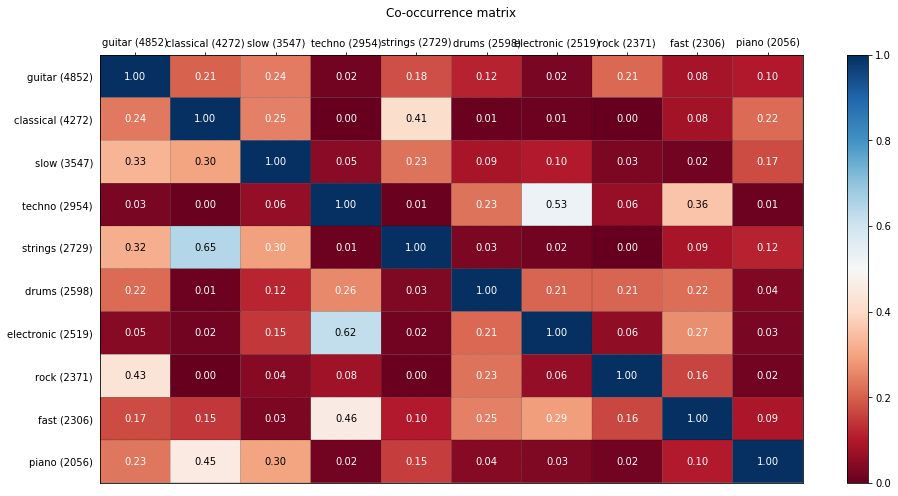

In [19]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, cleaned.loc[:,chosen_labels].values.astype(int))

## Load and format mp3 data 

### Create wav files from the mp3 dataset

You should not run this, it was only supposed to be used once for converting all mp3 files.

In [20]:
def from_mp3_to_wav(files, wav_dir):
    print("Start converting files from mp3 to wav...")
    count = 0
    for file_name in files :
        
        file_name_cut = file_name[len(DATA_DIRECTORY):-4]

        dir_path = wav_dir + file_name_cut[:2]

        new_file_name = wav_dir + file_name_cut + ".wav"
        
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        try :
            y, sr = librosa.load(file_name, sr=None, mono=True)
            librosa.output.write_wav(new_file_name, y, sr)
            
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", file_name) 
            
        count +=1
        if (count % 200) == 0:
            print(count)

In [ ]:
t0a = time.time()
files = find_files(DATA_DIRECTORY)
t1a = time.time()
from_mp3_to_wav(files, WAV_DIRECTORY)
t2a = time.time()

In [ ]:
print("Find files time : {:.3f} sec".format(t1a-t0a))
print("From mp3 to wav time : {:.2f} hours".format((t2a-t1a)/3600))

In [ ]:
print("Time to convert 1 song from mp3 to wav : {:.4f} sec".format((t2a-t1a)/FILE_NB))

# -------------start time tests---------------#

Need to clean this part later !

In [ ]:
n_songs = 100
labels = cleaned
labels_name = LABELS_NAME

t0 = time.time()
wav_files = find_files(WAV_DIRECTORY, pattern='*.wav', sample=n_songs)
print("Files found > start loading wav files")
print(WAV_DIRECTORY)
t1 = time.time()

count=0

audios_wav = np.ndarray(shape=(n_songs, BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
tags_wav = np.ndarray(shape=(n_songs, BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    
for wf in wav_files :
    # Load WAV file 
    try :
        audio, _ = librosa.load(wf, sr=None, mono=True)
    except EOFError :
        print("EOFERROR : The following file could not be loaded with librosa - ", filename)

    audio = audio.reshape(-1, 1)
    
    #create batches
    audio_batch = np.ndarray(shape=(BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    label_batch = np.ndarray(shape=(BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    for n in range(BATCH_NB) :
        audio_batch[n] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]

        # take labels or corresponding mp3 song
        select_labels  = labels.loc[labels['mp3_path'] ==wf[len(WAV_DIRECTORY):-4]+".mp3"]

        # select wanted labels
        select_labels = select_labels[labels_name]

        label_batch[n] = select_labels.values.reshape(NB_LABELS)

    audios_wav[count] = audio_batch
    tags_wav[count] = label_batch

    count +=1
    if (count % 10) == 0:
        print(count)
        
t2 = time.time()

In [ ]:
print("Loading time for 100 wav songs : {:.3f}".format(t2-t0))
print("Loading time for 1 wav songs : {:.4f}".format((t2-t0)/n_songs))

In [ ]:
n_songs = 100
labels = cleaned
labels_name = LABELS_NAME

t00 = time.time()
mp3_files = find_files(DATA_DIRECTORY, pattern='*.mp3', sample=n_songs)
print("Files found > start loading wav files")
print(DATA_DIRECTORY)
t11 = time.time()

count=0

audios_mp3 = np.ndarray(shape=(n_songs, BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
tags_mp3 = np.ndarray(shape=(n_songs, BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    
for mf in mp3_files :
    # Load MP3 file 
    try :
        audio, _ = librosa.load(mf, sr=None, mono=True)
    except EOFError :
        print("EOFERROR : The following file could not be loaded with librosa - ", filename)

    audio = audio.reshape(-1, 1)
    
    #create batches
    audio_batch = np.ndarray(shape=(BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    label_batch = np.ndarray(shape=(BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    for n in range(BATCH_NB) :
        audio_batch[n] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]

        # take labels or corresponding mp3 song
        select_labels  = labels.loc[labels['mp3_path'] ==mf[len(DATA_DIRECTORY):-4]+".mp3"]

        # select wanted labels
        select_labels = select_labels[labels_name]

        label_batch[n] = select_labels.values.reshape(NB_LABELS)

    audios_mp3[count] = audio_batch
    tags_mp3[count] = label_batch

    count +=1
    if (count % 10) == 0:
        print(count)
        
t22 = time.time()

In [ ]:
print("Loading time for 100 mp3 songs : {:.3f}".format(t22-t00))
print("Loading time for 1 mp3 songs : {:.4f}".format((t22-t00)/n_songs))

# -------------end time tests---------------#

### Loading audio & tags

In [21]:
# TODO : not efficient to 
# - give the whole label dataset to the function as argument
# - look in the label dataset at each iteration to retrieve the label
#   > should concat before randomize
# - append to an array and then convert to numpy ? > check

# labels_name : liste of columns name which we want to load

# Use Example 
# load_audio_label(cleaned, num_songs=100, directory=WAV_DIRECTORY, sub_dir=TRAIN_DIR, file_type="wav")

def load_audio_label(labels, num_songs=NB_SONGS, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav"):
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)

    if file_type=="mp3" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir)
    if file_type=="wav" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
 
    randomized_files = randomize_files(files)
    count = 0
    audios = np.ndarray(shape=(num_songs, BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs, BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    
    for filename in randomized_files:

        # Load audio (MP3/WAV) file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)

        #create batches
        audio_batch = np.ndarray(shape=(BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
        label_batch = np.ndarray(shape=(BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
        for n in range(BATCH_NB) :
            audio_batch[n] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding song
            
            if file_type=="mp3" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):]]
            
            if file_type=="wav" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):-4]+".mp3"]

            # select wanted labels
            select_labels = select_labels[labels_name]

            label_batch[n] = select_labels.values.reshape(NB_LABELS)
        
        audios[count] = audio_batch
        tags[count] = label_batch
        
        count +=1
        if (count % 10) == 0:
            print(count)

    return audios, tags

In [22]:
# load audios and labels > convert to numpy
# CAREFUL : the argument num_songs is important and shouldn't be too big 
# > otherwise MEMORY ISSUES !!!!!!
print("Loading data ...")
start = time.time()
audios, tags = load_audio_label(cleaned, sub_dir=TRAIN_DIR, \
                                file_type="wav", directory=WAV_DIRECTORY)
end = time.time()
duration = end-start
print(">> Total loading time - {} songs : {:.2f} sec".format(NB_SONGS, duration))

Loading data ...
10
20
>> Total loading time - 20 songs : 6.26 sec


In [23]:
print("Shape of audios list :")
print(audios.shape)
print()
print(">> shape is : [num_song, num_batches, batch_size, 1]")


Shape of audios list :
(20, 9, 51776, 1)

>> shape is : [num_song, num_batches, batch_size, 1]


In [24]:
print("Shape of tags list :")
print(tags.shape)
print()
print(">> shape is : [num_song, num_labels (mp3 file and id excluded), 1] ")
print("(or : [num_song, num_labels, 1, str_len, 1])")

Shape of tags list :
(20, 9, 2)

>> shape is : [num_song, num_labels (mp3 file and id excluded), 1] 
(or : [num_song, num_labels, 1, str_len, 1])


In [25]:
# put all batches at the same level (remove song dimension in the array)
# ex : go from dimensions (n, m, k, 1) > to (n*m, k, 1)
audios_flatten = audios.reshape(-1, audios.shape[-2], audios.shape[-1])
tags_flatten = tags.reshape(-1, tags.shape[-1])

## Neural Network model

### Save neural net state tool

In [26]:
# not used for now
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

### Initialize tf

In [27]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

### Training

In [28]:
# keep results for plotting
train_loss_results = []
train_auc_results = []

In [29]:
# Lines used to understand local vs global vs trainable
'''print("GLOBAL :", [str(i.name) for i in tf.global_variables()])
    print("LOCAL :", [str(i.name) for i in tf.local_variables()])
    print("TRAINABLE :",[str(i.name) for i in tf.trainable_variables()]) '''

'print("GLOBAL :", [str(i.name) for i in tf.global_variables()])\n    print("LOCAL :", [str(i.name) for i in tf.local_variables()])\n    print("TRAINABLE :",[str(i.name) for i in tf.trainable_variables()]) '

In [30]:
print("Initializing tf model ...")

audio_tf= tf.convert_to_tensor(audios_flatten, np.float32)
print("Input shape : {}".format(audio_tf.shape))
print("Labels : {}".format(tags_flatten.flatten()))
print()

net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags_flatten, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags_flatten, predictions=predictions)


# Saver for storing checkpoints of the model. (Wavenets)
saver = tf.train.Saver(var_list=tf.global_variables())
    
print("Start training...")

start = time.time()

with tf.Session() as sess:
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess.run(init)
    
    for i in tqdm(range(EPOCHS)):
        predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
        
        auc_result, update_op = auc_score
        
        train_loss_results.append(loss_value)
        train_auc_results.append(auc_result)
        
        print("Iter: {:2}, Loss: {:.4f}, AUC : {:.4f}".format(i, loss_value, auc_result))
        #print("Predictions : {}".format(predict.flatten()))
        #print()
     
    # use wavenet function > see later (for now simplest way)
    #save(saver, sess, LOGDIR, EPOCHS)
    saver.save(sess, LOGDIR)

end = time.time()
duration2 = end-start
print("Total time: {:.2f} sec.".format(duration2))

Initializing tf model ...
Input shape : (180, 51776, 1)
Labels : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0

Iter:  0, Loss: 0.9333, AUC : 0.0000
Iter:  1, Loss: 0.8824, AUC : 0.2204
Iter:  2, Loss: 0.8398, AUC : 0.4338
Iter:  3, Loss: 0.8036, AUC : 0.5716
Iter:  4, Loss: 0.7788, AUC : 0.6667
Iter:  5, Loss: 0.7613, AUC : 0.7306
Iter:  6, Loss: 0.7514, AUC : 0.7748
Iter:  7, Loss: 0.7442, AUC : 0.8022
Iter:  8, Loss: 0.7397, AUC : 0.8252
Iter:  9, Loss: 0.7371, AUC : 0.8442
Iter: 10, Loss: 0.7353, AUC : 0.8579
Iter: 11, Loss: 0.7343, AUC : 0.8686
Iter: 12, Loss: 0.7327, AUC : 0.8770
Iter: 13, Loss: 0.7321, AUC : 0.8835
Iter: 14, Loss: 0.7315, AUC : 0.8885
Iter: 15, Loss: 0.7311, AUC : 0.8926
Iter: 16, Loss: 0.7308, AUC : 0.8960
Iter: 17, Loss: 0.7306, AUC : 0.8986
Iter: 18, Loss: 0.7304, AUC : 0.9010
Iter: 19, Loss: 0.7303, AUC : 0.9035
Iter: 20, Loss: 0.7302, AUC : 0.9054
Iter: 21, Loss: 0.7301, AUC : 0.9072
Iter: 22, Loss: 0.7300, AUC : 0.9089
Iter: 23, Loss: 0.7299, AUC : 0.9109
Iter: 24, Loss: 0.7298, AUC : 0.9125
Iter: 25, Loss: 0.7298, AUC : 0.9140
Iter: 26, Loss: 0.7298, AUC : 0.9154
I

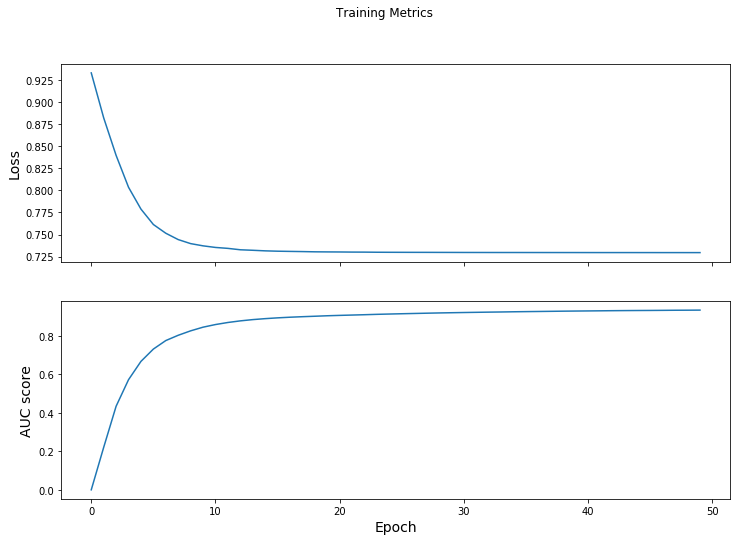

In [31]:
# modify this : the epoch axis not not integers which doesn't make sense
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("AUC score", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_auc_results)
plt.show()

## Test set

In [32]:
TEST_SIZE = 10

audios_test, tags_test = load_audio_label(cleaned, num_songs=TEST_SIZE, sub_dir=TEST_DIR)

audios_test = audios_test.reshape(-1, audios_test.shape[-2], audios_test.shape[-1])
tags_test = tags_test.reshape(-1, tags_test.shape[-1])

audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)


10


In [33]:
variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
      # Restore variables from disk.
    saver.restore(sess, LOGDIR)
    print("Model restored.")
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init) 

    predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

INFO:tensorflow:Restoring parameters from checkpoints/
Model restored.


In [34]:
# Print some results 
print("AUC Score :", predicts[4])

AUC Score : (0.0, 0.25950295)


In [35]:
print("PREDICTIONS :", predicts[1])
print("TRUE :", tags_test)

PREDICTIONS : [[0.45768988 0.34424967]
 [0.40885735 0.2848935 ]
 [0.4548959  0.33896983]
 [0.6222928  0.24535187]
 [0.34733555 0.43668178]
 [0.47935987 0.35609186]
 [0.4718343  0.27246812]
 [0.54273474 0.22356121]
 [0.56624687 0.2718722 ]
 [0.5212986  0.27925238]
 [0.35513446 0.3318452 ]
 [0.5127918  0.37382936]
 [0.4802518  0.25148618]
 [0.40309003 0.25665268]
 [0.594305   0.28470203]
 [0.53997093 0.33600947]
 [0.3187251  0.30771005]
 [0.44714713 0.34178025]
 [0.44508964 0.5139853 ]
 [0.35548255 0.41854742]
 [0.4229921  0.267793  ]
 [0.6378571  0.28201392]
 [0.5199904  0.35904086]
 [0.48223105 0.36018735]
 [0.42327833 0.37729684]
 [0.44798237 0.34801915]
 [0.4636852  0.27276453]
 [0.45486483 0.26602826]
 [0.6949176  0.21301603]
 [0.50790876 0.291939  ]
 [0.66778064 0.34050795]
 [0.46393037 0.37767333]
 [0.44271377 0.456553  ]
 [0.44603026 0.3595928 ]
 [0.5833367  0.29755247]
 [0.4109659  0.38074374]
 [0.4764103  0.20746157]
 [0.60589606 0.49448314]
 [0.5806476  0.54047054]
 [0.6810249

In [ ]:
# Useless for now
tf.reset_default_graph()

sess = tf.Session() 

last_checkpoint = "./" # >> check what argument was passed when running wavenets

from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
latest_ckp = tf.train.latest_checkpoint(last_checkpoint)

print_tensors_in_checkpoint_file(latest_ckp, all_tensors=True, tensor_name='')


variables_to_restore_glob = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

#variables_to_restore_loc = {
 #   var.name[:-2]: var for var in tf.local_variables()
  #  if not ('state_buffer' in var.name or 'pointer' in var.name)}

variables_to_restore = dict(variables_to_restore_glob)
#variables_to_restore.update(variables_to_restore_loc)

saver = tf.train.Saver(variables_to_restore)

print('Restoring model from {}'.format(last_checkpoint))
saver.restore(sess, last_checkpoint)


    
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

sess.run(init) 

predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

## Other structure (test)

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb